### Project 3 : Recommendation Systems

- <b>Gaurav Singh
- <b>305353434

In [662]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.similarities import pearson
from surprise.model_selection.validation import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import KFold
from surprise.prediction_algorithms.matrix_factorization import NMF
from surprise.prediction_algorithms.matrix_factorization import SVD

from surprise.dataset import Dataset
from surprise.reader import Reader

from surprise import accuracy
from sklearn import metrics

from sklearn.metrics import mean_squared_error

In [24]:
# Reading the data and constructing the ratings matrix (R)

ratings = pd.read_csv('./Synthetic_Movie_Lens/ratings.csv', delimiter=',')
movieNames = pd.read_csv('./Synthetic_Movie_Lens/movies.csv', delimiter=',')

In [308]:
genreDict = {}
genreFrame = movieNames['genres'].apply(lambda x: x.split('|')).to_numpy()

In [309]:
for x in genreFrame:
    for g in x:
        if g in genreDict:
            genreDict[g] = genreDict[g] + 1
        else:
            genreDict[g] = 1

In [312]:
# Distirbution of movies in different genres
genreDict

{'Adventure': 1263,
 'Animation': 611,
 'Children': 664,
 'Comedy': 3756,
 'Fantasy': 779,
 'Romance': 1596,
 'Drama': 4361,
 'Action': 1828,
 'Crime': 1199,
 'Thriller': 1894,
 'Horror': 978,
 'Mystery': 573,
 'Sci-Fi': 980,
 'War': 382,
 'Musical': 334,
 'Documentary': 440,
 'IMAX': 158,
 'Western': 167,
 'Film-Noir': 87,
 '(no genres listed)': 34}

In [314]:
# Total genres
print("Total number of genres: {}".format(len(genreDict)))

Total number of genres: 20


In [25]:
ratings = ratings.drop(columns=['Unnamed: 0', 'timestamp']).sort_values(by=['userId'])

In [26]:
print("Number of unique movies: ", ratings['movieId'].nunique())
print("Number of unique users: ", ratings['userId'].nunique())

Number of unique movies:  9724
Number of unique users:  610


In [31]:
moviesDict = {}
sortedData = ratings.sort_values(by = ['movieId'])
for id in sortedData['movieId'].unique():
    idx = str(movieNames[movieNames['movieId'] == id]['title']).split()[0]
    moviesDict[id] = movieNames[movieNames['movieId'] == id].title[int(idx)]

In [43]:
Rmat = np.zeros((ratings['userId'].nunique(), ratings['movieId'].nunique()))
array = np.array(sortedData)

In [44]:
moviesIdx = {}
id = 0
for i in range(len(array)):
    user_id = array[i, 0]
    rating = array[i, 2]
    movieId = array[i, 1]
    
    if movieId in moviesIdx:
        currId = moviesIdx[movieId]
    else:
        moviesIdx[movieId] = id
        id = id + 1
    
    Rmat[int(user_id - 1), moviesIdx[movieId]] = rating

In [47]:
NaNMat = Rmat.copy()
NaNMat[NaNMat == 0] = np.nan

In [48]:
# Sparsity
users = Rmat.shape[0]
movies = Rmat.shape[1]
totalPossible = users * movies
nonZero = np.count_nonzero(Rmat)

sparsity = nonZero / totalPossible

In [49]:
print("Sparsity of movie rating dataset: ", sparsity)

Sparsity of movie rating dataset:  0.016999683055613623


In [50]:
bins = np.arange(1, 5.5, 0.5)
counts = np.zeros(len(bins))

In [51]:
counts[0] = np.count_nonzero(np.logical_and(Rmat > 0, Rmat <= 1))

for i in range(len(bins)):
    if i == 0:
        continue
    
    counts[i] = np.count_nonzero(np.logical_and(Rmat > bins[i-1], Rmat <= bins[i]))

Text(0.5, 1.0, 'Ratings distribution')

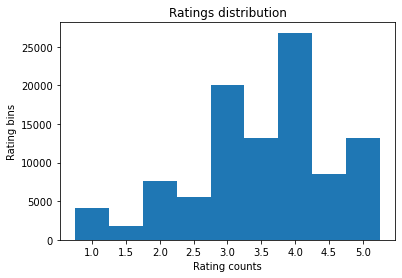

In [52]:
# Plotting bar char
plt.bar(bins, counts, width=0.5)
plt.xticks(bins)
plt.xlabel("Rating counts")
plt.ylabel("Rating bins")
plt.title("Ratings distribution")

In [53]:
# Rating distribution among movies
ratingPerMovie = np.count_nonzero(Rmat, axis = 0)
columnIds = np.array([*moviesIdx])

In [729]:
sortedIndices = np.argsort(-1 * ratingPerMovie)
sortedRatings = ratingPerMovie[sortedIndices]

Text(0.5, 1.0, 'No. of Ratings per movie')

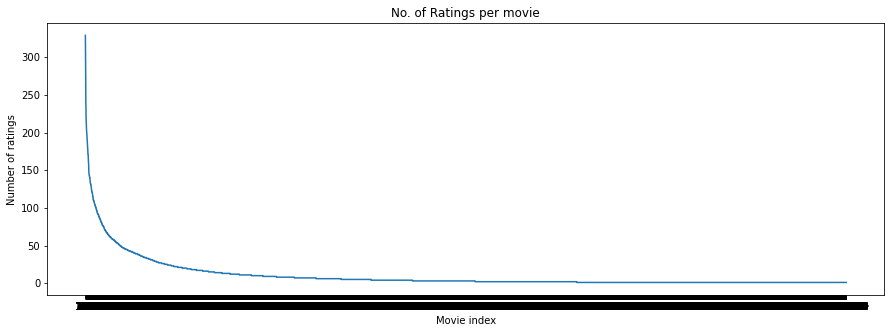

In [730]:
plt.figure(figsize=(15, 5))
plt.plot(columnIds.astype(str), sortedRatings)
plt.xlabel("Movie index")
plt.ylabel("Number of ratings")
plt.title("No. of Ratings per movie")

Text(0.5, 1.0, 'No. of Ratings per User')

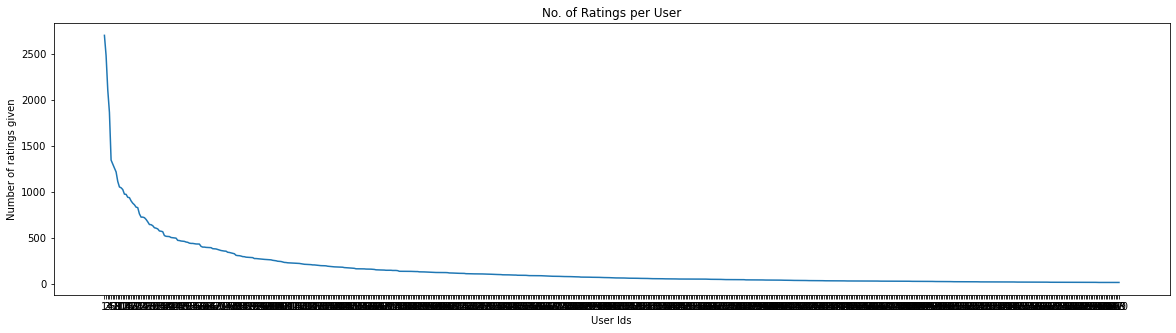

In [56]:
ratingPerUser = np.count_nonzero(Rmat, axis = 1)
Userids = np.arange(len(Rmat)) + 1

sortedIndices = np.argsort(-1 * ratingPerUser)
sortedRatings = ratingPerUser[sortedIndices]

plt.figure(figsize=(20, 5))
plt.plot(Userids.astype(str), sortedRatings)
plt.xlabel("User Ids")
plt.ylabel("Number of ratings given")
plt.title("No. of Ratings per User")

The number of ratings provided by each user is quite less. Most of the user have given ratings for only 20- 25 movies and only a few have provided ratings for good number of movies. Given there are ~10000 movies, this number is very low and thus the recommendations will skewed towards the highly rated movies and would be influenced by user who have rated heavily. 

Also the above plots thus justify why the Ratings matrix is highly sparse. 

Text(0.5, 1.0, 'Variance counts of movie ratings')

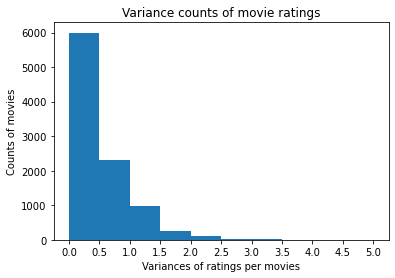

In [57]:
# Binned variances excluding NaN

variances = np.nanvar(NaNMat, axis=0)

plt.hist(variances, bins=np.arange(0, np.max(variances), 0.5))
plt.xticks(np.arange(0, np.max(variances), 0.5))
plt.xlabel("Variances of ratings per movies")
plt.ylabel("Counts of movies")
plt.title("Variance counts of movie ratings")

### Question 1:

<b>(a). </b> Sparsity of movie rating dataset:  <b>0.016999683055613623 </b>
     This indicates the dataset is very sparse and that only a few movies are rated by each user.

<b>(b). </b> Frequency of movie ratings:

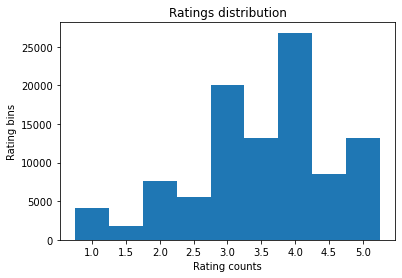

The distribution is negatively skewed which implies the median is greater than the mean. Also it means that users tend to given higher ratings 3 - 4 to a movie which is true because users watch those movies more which are highly rated.
Also the partial ratings are less compared to integral ratings because humans tend to give whole number ratings more.

<b>(c).</b> Distribution of the number of ratings received among movies:
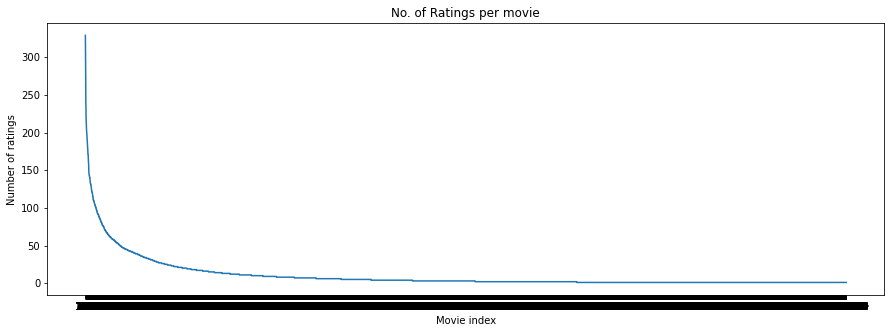

There are a lot of movies which received low number of ratings by users. There are only a few movies which received sufficiently large number of ratings by users.

<b>(d).</b> Distribution of ratings among users:
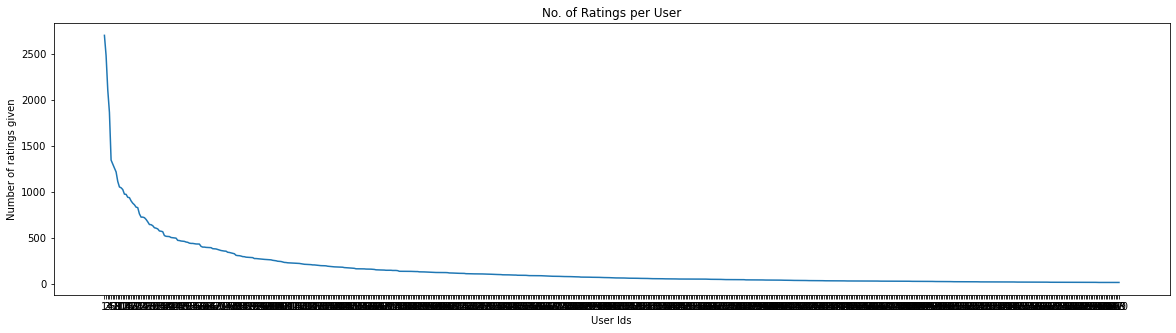

There are a few users who have given high number of ratings but most of the users have given less number of ratings to the items (movies).

<b>(e).</b> The number of ratings provided by each user is quite less. Most of the user have given ratings for only 20- 25 movies and only a few have provided ratings for good number of movies. Given there are ~10000 movies, this number is very low and thus the recommendations will skewed towards the highly rated movies and would be influenced by user who have rated heavily.

Also the above plots thus justify why the Ratings matrix is highly sparse.

The distributions are monotonically decreasing which implies that there are movies which are watched and rated by many users compared to others and thus in machine learning it will lead to inherent biasness towards these movies. The model will tend to perform better on such largely rated movies and will give average performance on the remaining most of the movies. This can be dealt with regularization.

<b>(f). </b> Variance of the rating values received by each movie:
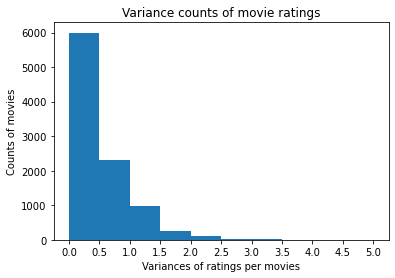

From the above plot I see that the variance in ratings for most of the movies is on the lower end that is most users for most films agree on the fact if a movie is good or bad and given almost similar ratings compared to some movies which show high variance.

The distribution is positively skewed.

### Question 2

#### (a). Formula for $\mu_u$

<center>$\mu_u = \frac{\sum_{k \in I_{u}} r_{uk}}{|I_{u}|}$ </center>



<b>(b).</b> $I_{u} \cap I_{v}$ represents the set of movies which are rated by both user u and v.
Yes this set can be empty given there is no common movies rated by either of the two users and since the R matrix is highly sparse this can happen.

### Question 3

This mean-centering process helps reduce the influence of outliers, and reduce bias in our predictions.

This would remove the effect of users that only give high/low ratings of movies, since the low variance of their rankings suggests that their opinions on movies are biased and may not be suitable for movie recommendations.


### Question 4

In [75]:
data = ratings

sim_options = {
    'name': 'pearson',
    'user_based': True
}

readerObj = Reader(rating_scale=(0.5, 5))

# Loading dataset from dataframe
readData = Dataset.load_from_df(data, readerObj)

In [80]:
# Evaluating k-NN collaborative filtering

KSweeps = np.arange(2, 102, 2)
avgRMSE = []
avgMAE = []

kf = KFold(n_splits=10)
for id,k in enumerate(KSweeps):
    if id % 10 == 0:
        print("Iterations completed: {}".format(id))
    algo = KNNWithMeans(k = k, sim_options=sim_options, verbose=False)
    
    scores = cross_validate(algo, readData, measures=['RMSE', 'MAE'], cv=kf, verbose=False)
    avgRMSE.append(np.average(scores['test_rmse']))
    avgMAE.append(np.average(scores['test_mae']))

Iterations completed: 0
Iterations completed: 10
Iterations completed: 20
Iterations completed: 30
Iterations completed: 40


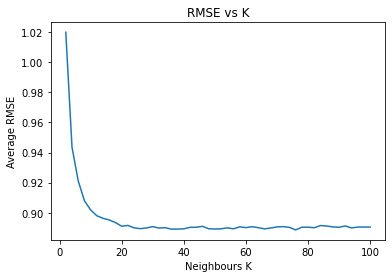

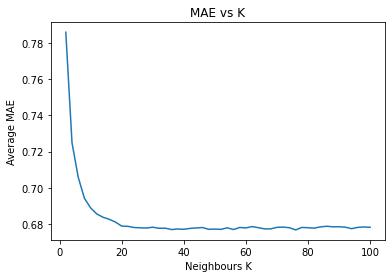

In [83]:
# Plotting the error scores

plt.plot(KSweeps, avgRMSE)
plt.xlabel("Neighbours K")
plt.ylabel("Average RMSE")
plt.title("RMSE vs K")
plt.show()

plt.plot(KSweeps, avgMAE)
plt.xlabel("Neighbours K")
plt.ylabel("Average MAE")
plt.title("MAE vs K")
plt.show()

In [95]:
# Steady state errors
minKRMSE = 20
minKMAE = 20

steadyRMSE = np.average(avgRMSE[(int(minKRMSE / 2) - 1):])
steadyMAE = np.average(avgMAE[(int(minKMAE / 2) - 1):])

In [519]:
print("Steady State error values for Avg RMSE occur at {} with average errors: {} ".format(minKRMSE, steadyRMSE))
print("Steady State error values for Avg MAE occur at {} with average errors: {} ".format(minKMAE, steadyMAE))

Steady State error values for Avg RMSE occur at 20 with average errors: 0.8901762086778877 
Steady State error values for Avg MAE occur at 20 with average errors: 0.6777551301277386 


### Question 5

Using the errors plot from above, minimum k is : <b> 20 </b>
    
Steady State error values for Avg RMSE occur at 20 with average errors: <b>0.8901762086778877</b>  </br>
Steady State error values for Avg MAE occur at 20 with average errors: <b>0.6777551301277386 </b>

In [521]:
# Extracting different testset

varianceDict = ratings.groupby('movieId')['rating'].var().to_dict()
numRatings = ratings.groupby('movieId')['rating'].count().to_dict()

def getPopular(test):
    return [x for x in test if numRatings[x[1]] > 2]

def getUnpopular(test):
    return [x for x in test if numRatings[x[1]] <= 2]

def highVar(test):
    return [x for x in test if (varianceDict[x[1]] >= 2 and numRatings[x[1]] >= 5)]

In [522]:
# Evaluating on trimmed set
KSweeps = np.arange(2, 102, 2)
kf = KFold(n_splits=10)

avgPopular = []
avgUnpopular = []
avgHighVar = []

for id, k in enumerate(KSweeps):
    if k % 10 == 0:
        print("Sweeps completed: {}".format(k))
    algo = KNNWithMeans(k = k, sim_options=sim_options, verbose=False)
    
    pop = []
    unpop = []
    hvar = []
    for trainset, testset in kf.split(readData):
        tpop = getPopular(testset)
        tunpop = getUnpopular(testset)
        thvar = highVar(testset)
        
        algo.fit(trainset)
        
        predpop = algo.test(tpop)
        predunpop = algo.test(tunpop)
        predhvar = algo.test(thvar)

        pop.append(accuracy.rmse(predpop, verbose=False))
        unpop.append(accuracy.rmse(predunpop, verbose=False))
        hvar.append(accuracy.rmse(predhvar, verbose=False))
    
    avgPopular.append(np.mean(np.array(pop)))
    avgUnpopular.append(np.mean(np.array(unpop)))
    avgHighVar.append(np.mean(np.array(hvar)))

Sweeps completed: 10
Sweeps completed: 20
Sweeps completed: 30
Sweeps completed: 40
Sweeps completed: 50
Sweeps completed: 60
Sweeps completed: 70
Sweeps completed: 80
Sweeps completed: 90
Sweeps completed: 100


### Question 6

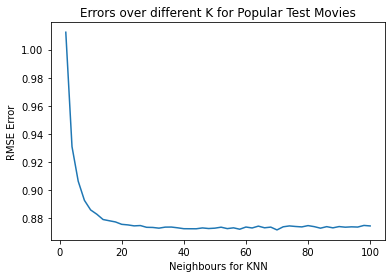

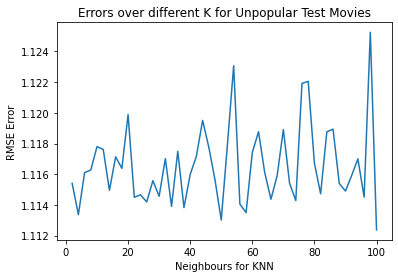

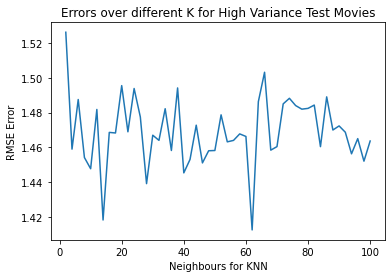

In [523]:
# Plotting the RMSE scores for different test sets 

plt.plot(KSweeps, avgPopular)
plt.xlabel("Neighbours for KNN")
plt.ylabel("RMSE Error")
plt.title("Errors over different K for Popular Test Movies")
plt.show()

plt.plot(KSweeps, avgUnpopular)
plt.xlabel("Neighbours for KNN")
plt.ylabel("RMSE Error")
plt.title("Errors over different K for Unpopular Test Movies")
plt.show()

plt.plot(KSweeps, avgHighVar)
plt.xlabel("Neighbours for KNN")
plt.ylabel("RMSE Error")
plt.title("Errors over different K for High Variance Test Movies")
plt.show()

Minimum avg. RMSE for popular testset: <b>0.8717650563990811</b> </br>
K at which minimum occurs for popular testset: 70

Minimum avg. RMSE for unpopular testset: <b>1.1123738487253862</b> </br>
K at which minimum occurs for unpopular testset: 100

Minimum avg. RMSE for high variance testset: <b>1.4125821220516621</b> </br>
K at which minimum occurs for high variance testset: 62

In [735]:
print("Minimum errors using KNN with means for trimmed testsets\n")
print("Minimum avg. RMSE for popular testset: {}".format(np.min(avgPopular)))
print("K at which minimum occurs for popular testset: {}\n".format(KSweeps[np.argmin(avgPopular)]))

print("Minimum avg. RMSE for unpopular testset: {}".format(np.min(avgUnpopular)))
print("K at which minimum occurs for unpopular testset: {}\n".format(KSweeps[np.argmin(avgUnpopular)]))

print("Minimum avg. RMSE for high variance testset: {}".format(np.min(avgHighVar)))
print("K at which minimum occurs for high variance testset: {}\n".format(KSweeps[np.argmin(avgHighVar)]))


Minimum errors using KNN with means for trimmed testsets

Minimum avg. RMSE for popular testset: 0.8717650563990811
K at which minimum occurs for popular testset: 70

Minimum avg. RMSE for unpopular testset: 1.1123738487253862
K at which minimum occurs for unpopular testset: 100

Minimum avg. RMSE for high variance testset: 1.4125821220516621
K at which minimum occurs for high variance testset: 62



In [524]:
def plot_roc(fpr, tpr):
    #helper function taken from discussion notebook
    fig, ax = plt.subplots()

    roc_auc = metrics.auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=12)
    ax.set_ylabel('True Positive Rate',fontsize=12)

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(12)

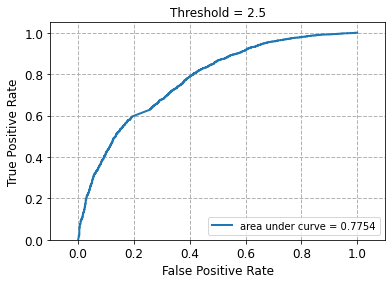

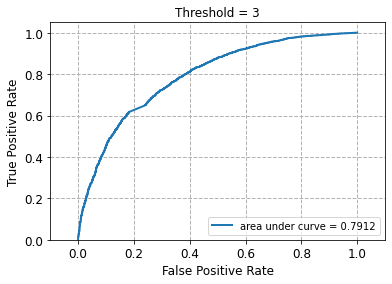

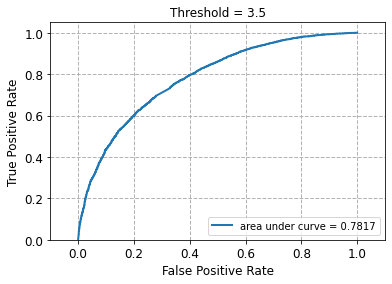

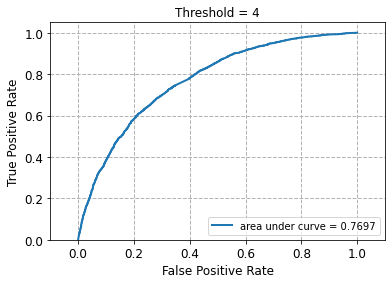

In [525]:
# Plotting the ROC Curves
threshold = [2.5, 3, 3.5, 4]

bestK = 20 #As seen above
for thresh in threshold:
    trainset, testset = train_test_split(readData, test_size=0.1)
    algo = KNNWithMeans(k = bestK, sim_options=sim_options, verbose=False)
    
    algo.fit(trainset)
    
    predictions = algo.test(testset)
    
    pred = []
    actual = []
    
    for p in predictions:
        #Actual values at pos 2 and predictions at pos 3
        pred.append(p[3])
        actual.append(int(p[2] >= thresh))
        
    fpr, tpr, thresholds = metrics.roc_curve(actual, pred, pos_label=1)
    plot_roc(fpr,tpr)
    plt.title("Threshold = {}".format(thresh))
    plt.show()

<b>For ROC Curves the chosen number of neighbours = <b>20</b> <br> The ROC Curves for different thresholds [2.5, 3, 3.5, 4] for KNN With Means are given above along with the AUC Scores. </b>

The AUC Scores for different threshold values are given below:

<b>2.5 - 0.7754 <br>
3.0 - 0.7912 <br>
3.5 - 0.7817<br>
4.0 - 0.7697

#### Model based collaborative filtering

### Question 7

No the optimization task in equation 5 is not convex. This can be analysed by taking m = n = 1 and seeing that Hessian of the function is <b>not always positive</b>.

If U is fixed, the corresponding optimization task in LS Form becomes:

</br>
<center>$\underset{V} {minimize} \sum^{m}_{i = 1} \sum^{n}_{j = 1} W_{ij}(r_{ij} - (UV^{T})_{ij})^2$ </center>

In [526]:
# NMF Collaborative Filter
NMFSweeps = np.arange(2, 52, 2)
avgRMSENMF = []
avgMAENMF = []

kf = KFold(n_splits=10)
for id,k in enumerate(NMFSweeps):
    if k % 5 == 0:
        print("Iterations completed: {}".format(id))
    algo = NMF(n_factors=k, verbose=False)
    
    scores = cross_validate(algo, readData, measures=['RMSE', 'MAE'], cv=kf, verbose=False)
    avgRMSENMF.append(np.average(scores['test_rmse']))
    avgMAENMF.append(np.average(scores['test_mae']))

Iterations completed: 4
Iterations completed: 9
Iterations completed: 14
Iterations completed: 19
Iterations completed: 24


### Question 8

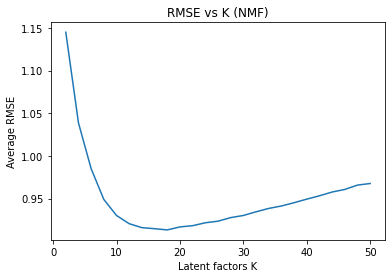

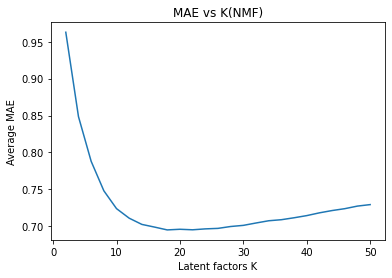

In [527]:
# Plotting the error scores for NMF

plt.plot(NMFSweeps, avgRMSENMF)
plt.xlabel("Latent factors K")
plt.ylabel("Average RMSE")
plt.title("RMSE vs K (NMF)")
plt.show()

plt.plot(NMFSweeps, avgMAENMF)
plt.xlabel("Latent factors K")
plt.ylabel("Average MAE")
plt.title("MAE vs K(NMF)")
plt.show()

In [528]:
NMFSweeps = np.arange(2, 52, 2)
kf = KFold(n_splits=10)

avgPopularNMF = []
avgUnpopularNMF = []
avgHighVarNMF = []

for id, k in enumerate(NMFSweeps):
    if k % 5 == 0:
        print("Sweeps completed: {}".format(k))
    algo = NMF(n_factors=k, verbose=False)
    
    pop = []
    unpop = []
    hvar = []
    for trainset, testset in kf.split(readData):
        tpop = getPopular(testset)
        tunpop = getUnpopular(testset)
        thvar = highVar(testset)
        
        algo.fit(trainset)
        
        predpop = algo.test(tpop)
        predunpop = algo.test(tunpop)
        predhvar = algo.test(thvar)

        pop.append(accuracy.rmse(predpop, verbose=False))
        unpop.append(accuracy.rmse(predunpop, verbose=False))
        hvar.append(accuracy.rmse(predhvar, verbose=False))
    
    avgPopularNMF.append(np.mean(np.array(pop)))
    avgUnpopularNMF.append(np.mean(np.array(unpop)))
    avgHighVarNMF.append(np.mean(np.array(hvar)))

Sweeps completed: 10
Sweeps completed: 20
Sweeps completed: 30
Sweeps completed: 40
Sweeps completed: 50


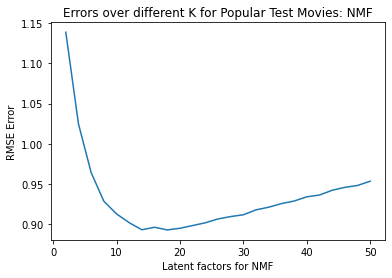

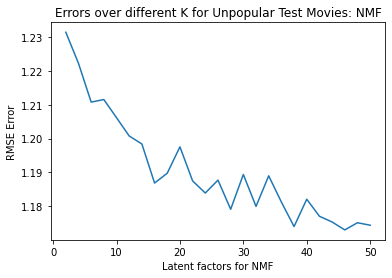

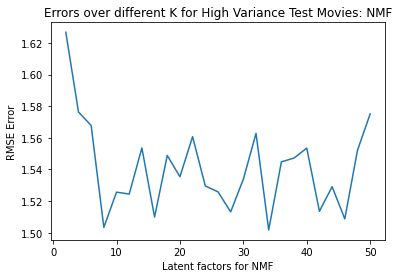

In [529]:
# Plotting the RMSE scores for different test sets using NMF

plt.plot(NMFSweeps, avgPopularNMF)
plt.xlabel("Latent factors for NMF")
plt.ylabel("RMSE Error")
plt.title("Errors over different K for Popular Test Movies: NMF")
plt.show()

plt.plot(NMFSweeps, avgUnpopularNMF)
plt.xlabel("Latent factors for NMF")
plt.ylabel("RMSE Error")
plt.title("Errors over different K for Unpopular Test Movies: NMF")
plt.show()

plt.plot(NMFSweeps, avgHighVarNMF)
plt.xlabel("Latent factors for NMF")
plt.ylabel("RMSE Error")
plt.title("Errors over different K for High Variance Test Movies: NMF")
plt.show()

In [530]:
# Minimum average RMSE for different trimmed sets

print("Minimum avg. RMSE for popular testset: {}".format(np.min(avgPopularNMF)))
print("K at which minimum occurs for popular testset: {}\n".format(NMFSweeps[np.argmin(avgPopularNMF)]))

print("Minimum avg. RMSE for unpopular testset: {}".format(np.min(avgUnpopularNMF)))
print("K at which minimum occurs for unpopular testset: {}\n".format(NMFSweeps[np.argmin(avgUnpopularNMF)]))

print("Minimum avg. RMSE for high variance testset: {}".format(np.min(avgHighVarNMF)))
print("K at which minimum occurs for high variance testset: {}\n".format(NMFSweeps[np.argmin(avgHighVarNMF)]))

Minimum avg. RMSE for popular testset: 0.8925146006662568
K at which minimum occurs for popular testset: 18

Minimum avg. RMSE for unpopular testset: 1.1729717428096795
K at which minimum occurs for unpopular testset: 46

Minimum avg. RMSE for high variance testset: 1.5017368319078694
K at which minimum occurs for high variance testset: 34



In [531]:
# Minimum average RMSE and MAE from cross validation
print("Minimum avg. RMSE for 10 Fold cross validation: {}".format(np.min(avgRMSENMF)))
print("K at which minimum RMSE occurs for 10 Fold cross validation:  {}\n".format(NMFSweeps[np.argmin(avgRMSENMF)]))

print("Minimum avg. MAE for 10 Fold cross validation: {}".format(np.min(avgMAENMF)))
print("K at which minimum MAE occurs for 10 Fold cross validation:  {}\n".format(NMFSweeps[np.argmin(avgMAENMF)]))

Minimum avg. RMSE for 10 Fold cross validation: 0.9133007458371984
K at which minimum RMSE occurs for 10 Fold cross validation:  18

Minimum avg. MAE for 10 Fold cross validation: 0.6950218120821128
K at which minimum MAE occurs for 10 Fold cross validation:  18



#### Account of errors RMSE and MAE for trimmed testsets and minimum average errors

Minimum avg. RMSE for 10 Fold cross validation: <b>0.9133007458371984</b> <br>
K at which minimum RMSE occurs for 10 Fold cross validation:  18<br>

Minimum avg. MAE for 10 Fold cross validation: <b>0.6950218120821128 </b><br>
K at which minimum MAE occurs for 10 Fold cross validation:  18<br>


Minimum avg. RMSE for popular testset: <b>0.8925146006662568</b><br>
K at which minimum occurs for popular testset: 18<br>

Minimum avg. RMSE for unpopular testset:<b> 1.1729717428096795</b><br>
K at which minimum occurs for unpopular testset: 46<br>

Minimum avg. RMSE for high variance testset:<b> 1.5017368319078694</b><br>
K at which minimum occurs for high variance testset: 34<br>

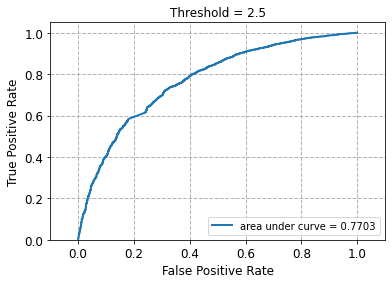

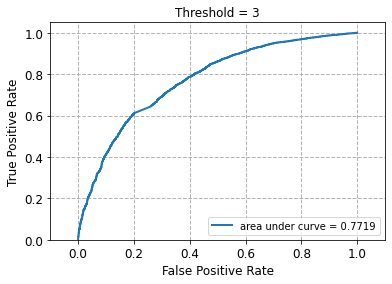

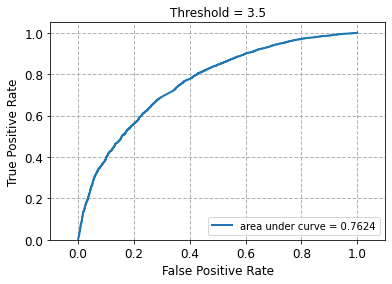

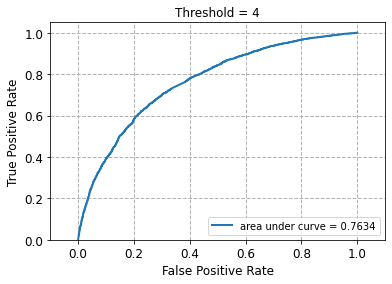

In [555]:
# Plotting the ROC Curves for NMF. Choosing K = 18
threshold = [2.5, 3, 3.5, 4]

bestNMFK = 18 #As seen above
for thresh in threshold:
    trainset, testset = train_test_split(readData, test_size=0.1)
    algo = NMF(n_factors=bestNMFK, verbose=False)
    
    algo.fit(trainset)
    
    predictions = algo.test(testset)
    
    pred = []
    actual = []
    
    for p in predictions:
        #Actual values at pos 2 and predictions at pos 3
        pred.append(p[3])
        actual.append(int(p[2] >= thresh))
        
    fpr, tpr, thresholds = metrics.roc_curve(actual, pred, pos_label=1)
    plot_roc(fpr,tpr)
    plt.title("Threshold = {}".format(thresh))
    plt.show()

Best K for NMF is <b>18</b> for RMSE error and 18 for MAE error. <br>

Total movie genres : 20. <b>(including no genre as a genre)</b><br>

Thus best number of latent factors are close to number of genres but not exactly same as to the number of genres.<br>

The AUC Scores for different threshold values are given below:

<b>2.5 - 0.7703 <br>
3.0 - 0.7719 <br>
3.5 - 0.7624<br>
4.0 - 0.7634

In [533]:
# NMF on ratings matrix

nGenres = len(genreDict)
algo = NMF(n_factors=nGenres, verbose=False, random_state=42)

trainset = readData.build_full_trainset()

algo.fit(trainset)

In [534]:
print("Shape of pu: {}".format(algo.pu.shape))
print("Shape of qi: {}".format(algo.qi.shape))
V = algo.qi

Shape of pu: (610, 20)
Shape of qi: (9724, 20)


In [535]:
topK = 10
topMovies = pd.DataFrame(0, index=np.arange(topK), columns=(np.arange(nGenres) + 1).astype('str'))

In [536]:
for i in range(nGenres):
    colV = V[:, i]
    indices = np.argsort(-colV)[0: topK]
    temp = np.zeros(topK).astype('str')
    for j, idx in enumerate(indices):
        movId = trainset.to_raw_iid(idx)
        temp[j] = movieNames[movieNames['movieId'] == trainset.to_raw_iid(idx)]['genres'].values[0]
    topMovies[str(i+1)] = temp.tolist()

In [537]:
topMovies

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,Drama,Drama|Horror|Mystery|Thriller,Drama|Romance,Action|Sci-Fi,Comedy,Horror,Drama|Mystery,Drama|Horror|Thriller,Drama|Fantasy|Mystery,Drama|Romance|Thriller,Action|Adventure|Sci-Fi|Thriller,Comedy|Documentary|Drama|Romance,Animation|Children|Comedy|Musica,Crime|Drama|Romance,Animation|Children|Comedy,Comedy|Drama|Romance|Thriller,Comedy|Drama,Drama,Comedy|Mystery,Fantasy|Horror
1,Action|Drama,Action|Drama,Comedy|Sci-Fi,Drama,Comedy,Comedy|Drama|Romance,Children|Comedy,Horror|Mystery|Thriller,Comedy,Comedy|Drama,Action|Comedy|Crime,Horror|Sci-Fi|Thriller,Horror,Comedy|Drama,Action|Comedy|Crime|Fantasy,Comedy|Drama,Drama,Comedy|Drama|Romance,Comedy,Crime|Horror|Thriller
2,Adventure|Thriller,Comedy|Drama|Horror,Adventure|Animation|Children,Adventure|Comedy|Sci-Fi|Thriller,Drama,Comedy,Comedy,Drama,Crime|Drama|Fantasy|Mystery|Thri,Drama|Mystery|Thriller,Comedy|Drama,Action|Fantasy|Horror|Sci-Fi|Thr,Film-Noir|Horror|Mystery|Thrille,Comedy|Drama,Comedy|Romance|Thriller,Action|Comedy|Horror|Thriller,Drama|Thriller,Drama|Film-Noir,Documentary|Musical,Animation|Children|Comedy|Musica
3,Thriller,Drama|Horror|Thriller,Comedy,Drama|Horror|Thriller,Comedy,Drama|Sci-Fi,Drama|Romance,Comedy|Crime|Mystery|Romance,Horror|Sci-Fi,Drama,Action|Crime|Thriller,Drama|Romance,Animation|Comedy|Drama|Fantasy|S,Fantasy|Horror|Thriller,Adventure|Children|Comedy,Animation|Comedy,Crime|Drama|Romance,Horror,Fantasy|Western,Drama|Thriller
4,Crime|Drama|Mystery,Children|Comedy,Drama|Film-Noir|Romance,Comedy|Drama|Musical,Comedy,Horror|Mystery|Thriller,Horror|Mystery|Thriller,Drama,Musical,Adventure|Children,Comedy|Romance,Drama|Romance,Action|Drama,Children|Comedy|Drama,Adventure|Children|Comedy,Drama|Thriller,Drama,Crime|Drama|Thriller,Comedy|Documentary,Horror|Thriller
5,Comedy|Drama|Musical,Horror|Mystery|Thriller,Comedy,Comedy|Romance,Drama,Drama,Comedy|Romance,Drama|Film-Noir,Comedy|Drama|War,Sci-Fi,Action|Adventure|Children|Myster,Drama|Romance,Comedy,Action|Comedy,Action|Crime|Drama|Thriller,Comedy|Horror,Action|Adventure,Action|Adventure|Animation|Sci-F,Comedy,Drama|Fantasy|Mystery
6,Drama,Action|Sci-Fi|Thriller|IMAX,Comedy|Drama|Romance,Comedy|Drama|Romance,Action|Sci-Fi,Crime|Horror|Mystery,Thriller,Action|Adventure|Drama|Thriller,Comedy,Comedy,Comedy,Drama|Thriller,Drama,Comedy|Drama,Comedy|Crime,Fantasy|Horror,Action|Crime|Thriller,Comedy|Crime|Mystery|Romance,Comedy,Action|Comedy
7,Action|Adventure|Animation,Drama|Romance,Comedy|Romance,Children|Comedy|Romance,Drama|Thriller,Comedy,Drama,Drama,Comedy|Romance,Drama,Action|Comedy|Crime,Action|Comedy|Crime|Fantasy,Drama|Fantasy|Mystery,Drama|Sci-Fi|War,Animation|Children|Comedy,Comedy|Drama|Romance,Children|Drama|Fantasy,Action|Horror|Sci-Fi,Action|Comedy|Romance|War,Comedy
8,Comedy|Romance,Drama|Thriller,Adventure|Comedy|Sci-Fi,Adventure|Fantasy,Comedy|Fantasy|Romance,Comedy|Drama|Romance,Action|Sci-Fi|Thriller,Crime|Drama,Comedy,Comedy,Comedy|Drama,Comedy|Romance,Action|Comedy,Comedy|Fantasy|Horror,Comedy|Drama|Romance,Comedy,Comedy,Action|Animation|Drama|Sci-Fi|Th,Comedy|Horror|Thriller,Comedy|Musical
9,Action|Animation|Mystery|Sci-Fi,Comedy,Comedy|Crime,Drama,Crime|Drama|Thriller,Comedy,Crime|Drama|Romance,Drama|Horror|Mystery|Thriller,Comedy|Crime,Comedy,Action|Drama|Fantasy,Comedy|Western,Action|Horror|Sci-Fi,Comedy|Romance,Children|Comedy,Drama|Romance|Sci-Fi,Drama|Romance|Thriller,Animation|Comedy,Comedy,Children|Comedy|Fantasy|Romance


### Question 9



From above account we see that top 10 movies belong to a small subset of genres. Its observed that each latent factor tend to group movies which are from the same genre. <br>

Eg. Latent factor 15 tends to group movies having genres Animation|Children|Comedy. <br>
Latent factor 19 tends to group movies having genre Comedy.<br>
Latent factor 12 tends to group movies having genre Drama|Romance<br>

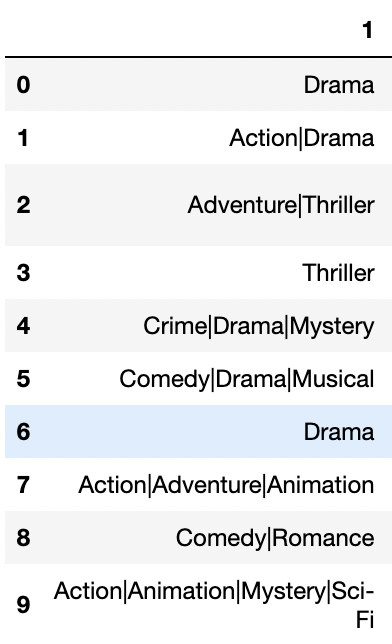

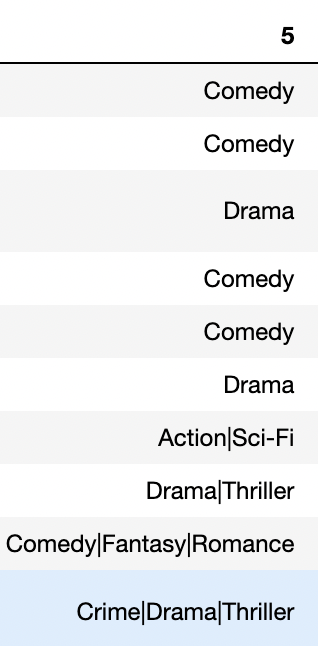

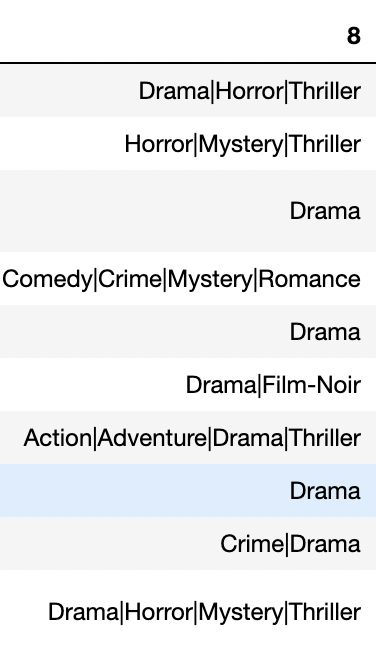

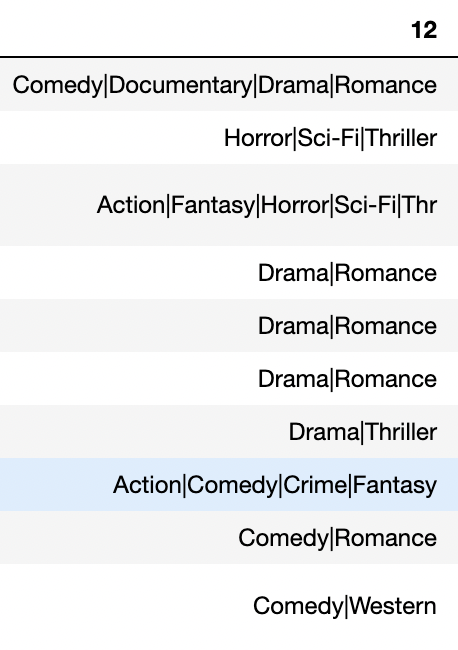

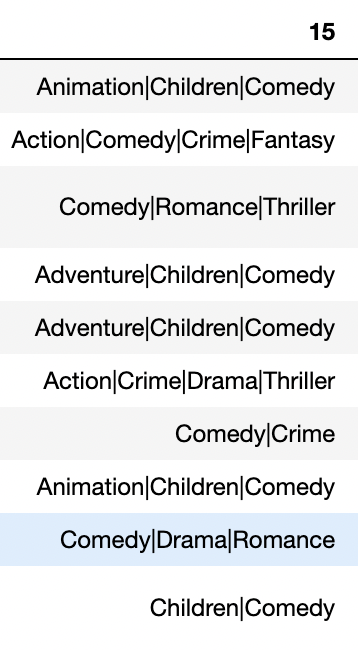

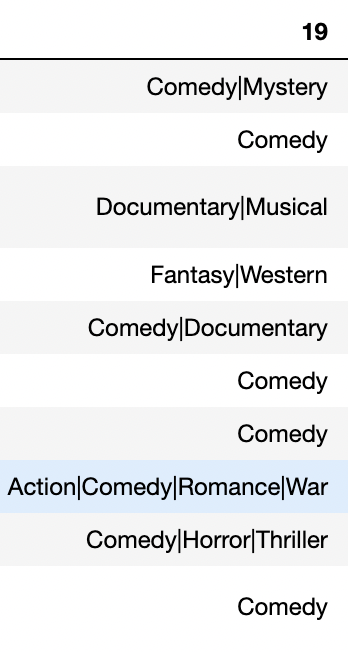

### MF Collaborative filter

In [552]:
SVDSweeps = np.arange(2, 52, 2)
avgRMSESVD = []
avgMAESVD = []

kf = KFold(n_splits=10)
for k in SVDSweeps:
    if k % 4 == 0:
        print("Iterations completed: {}".format(k))
    algo = SVD(n_factors=k, verbose=False, random_state=42)
    
    scores = cross_validate(algo, readData, measures=['RMSE', 'MAE'], cv=kf, verbose=False)
    avgRMSESVD.append(np.mean(scores['test_rmse']))
    avgMAESVD.append(np.mean(scores['test_mae']))

Iterations completed: 4
Iterations completed: 8
Iterations completed: 12
Iterations completed: 16
Iterations completed: 20
Iterations completed: 24
Iterations completed: 28
Iterations completed: 32
Iterations completed: 36
Iterations completed: 40
Iterations completed: 44
Iterations completed: 48


### Question 10

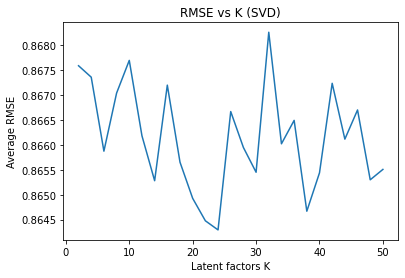

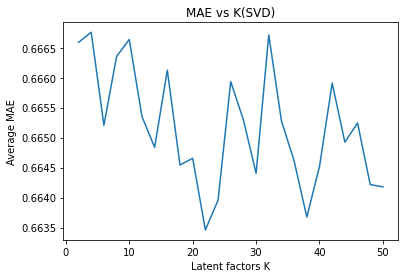

In [553]:
# Plotting the error scores for SVD

plt.plot(SVDSweeps, avgRMSESVD)
plt.xlabel("Latent factors K")
plt.ylabel("Average RMSE")
plt.title("RMSE vs K (SVD)")
plt.show()

plt.plot(SVDSweeps, avgMAESVD)
plt.xlabel("Latent factors K")
plt.ylabel("Average MAE")
plt.title("MAE vs K(SVD)")
plt.show()

In [540]:
SVDSweeps = np.arange(2, 52, 2)
kf = KFold(n_splits=10)

avgPopularSVD = []
avgUnpopularSVD = []
avgHighVarSVD = []

for id, k in enumerate(SVDSweeps):
    if k % 4 == 0:
        print("Sweeps completed: {}".format(k))
    algo = SVD(n_factors=k, verbose=False, random_state=42)
    
    pop = []
    unpop = []
    hvar = []
    for trainset, testset in kf.split(readData):
        tpop = getPopular(testset)
        tunpop = getUnpopular(testset)
        thvar = highVar(testset)
        
        algo.fit(trainset)
        
        predpop = algo.test(tpop)
        predunpop = algo.test(tunpop)
        predhvar = algo.test(thvar)

        pop.append(accuracy.rmse(predpop, verbose=False))
        unpop.append(accuracy.rmse(predunpop, verbose=False))
        hvar.append(accuracy.rmse(predhvar, verbose=False))
    
    avgPopularSVD.append(np.mean(np.array(pop)))
    avgUnpopularSVD.append(np.mean(np.array(unpop)))
    avgHighVarSVD.append(np.mean(np.array(hvar)))

Sweeps completed: 4
Sweeps completed: 8
Sweeps completed: 12
Sweeps completed: 16
Sweeps completed: 20
Sweeps completed: 24
Sweeps completed: 28
Sweeps completed: 32
Sweeps completed: 36
Sweeps completed: 40
Sweeps completed: 44
Sweeps completed: 48


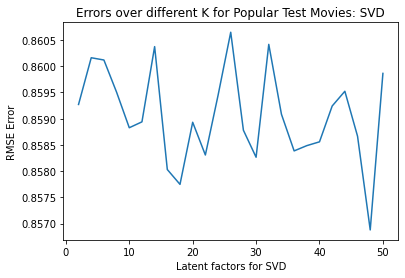

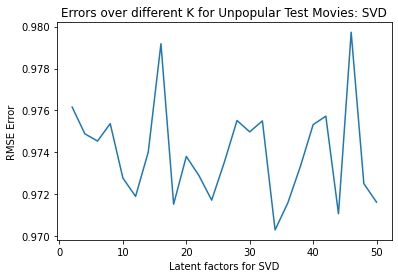

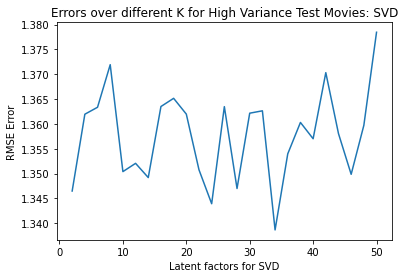

In [541]:
# Plotting the RMSE scores for different test sets using SVD

plt.plot(SVDSweeps, avgPopularSVD)
plt.xlabel("Latent factors for SVD")
plt.ylabel("RMSE Error")
plt.title("Errors over different K for Popular Test Movies: SVD")
plt.show()

plt.plot(SVDSweeps, avgUnpopularSVD)
plt.xlabel("Latent factors for SVD")
plt.ylabel("RMSE Error")
plt.title("Errors over different K for Unpopular Test Movies: SVD")
plt.show()

plt.plot(SVDSweeps, avgHighVarSVD)
plt.xlabel("Latent factors for SVD")
plt.ylabel("RMSE Error")
plt.title("Errors over different K for High Variance Test Movies: SVD")
plt.show()

In [542]:
# Minimum average RMSE for different trimmed sets using SVD

print("Minimum avg. RMSE for popular testset: {}".format(np.min(avgPopularSVD)))
print("K at which minimum occurs for popular testset: {}\n".format(SVDSweeps[np.argmin(avgPopularSVD)]))

print("Minimum avg. RMSE for unpopular testset: {}".format(np.min(avgUnpopularSVD)))
print("K at which minimum occurs for unpopular testset: {}\n".format(SVDSweeps[np.argmin(avgUnpopularSVD)]))

print("Minimum avg. RMSE for high variance testset: {}".format(np.min(avgHighVarSVD)))
print("K at which minimum occurs for high variance testset: {}\n".format(SVDSweeps[np.argmin(avgHighVarSVD)]))

Minimum avg. RMSE for popular testset: 0.8568788058477971
K at which minimum occurs for popular testset: 48

Minimum avg. RMSE for unpopular testset: 0.9703111077960956
K at which minimum occurs for unpopular testset: 34

Minimum avg. RMSE for high variance testset: 1.3386569097126166
K at which minimum occurs for high variance testset: 34



In [554]:
# Minimum average RMSE and MAE from cross validation
print("Minimum avg. RMSE for 10 Fold cross validation: {}".format(np.min(avgRMSESVD)))
print("K at which minimum RMSE occurs for 10 Fold cross validation:  {}\n".format(SVDSweeps[np.argmin(avgRMSESVD)]))

print("Minimum avg. MAE for 10 Fold cross validation: {}".format(np.min(avgMAESVD)))
print("K at which minimum MAE occurs for 10 Fold cross validation:  {}\n".format(SVDSweeps[np.argmin(avgMAESVD)]))

Minimum avg. RMSE for 10 Fold cross validation: 0.8642942130694257
K at which minimum RMSE occurs for 10 Fold cross validation:  24

Minimum avg. MAE for 10 Fold cross validation: 0.6634607909132904
K at which minimum MAE occurs for 10 Fold cross validation:  22



#### Account of errors RMSE and MAE for trimmed testsets and minimum average errors

Minimum avg. RMSE for 10 Fold cross validation: <b>0.8642942130694257</b> <br>
K at which minimum RMSE occurs for 10 Fold cross validation:  24

Minimum avg. MAE for 10 Fold cross validation: <b>0.6634607909132904</b> <br>
K at which minimum MAE occurs for 10 Fold cross validation:  22

Minimum avg. RMSE for popular testset: <b>0.8568788058477971 </b> <br>
K at which minimum occurs for popular testset: 48

Minimum avg. RMSE for unpopular testset: <b>0.9703111077960956 </b> <br>
K at which minimum occurs for unpopular testset: 34

Minimum avg. RMSE for high variance testset: <b>1.3386569097126166 </b> <br>
K at which minimum occurs for high variance testset: 34

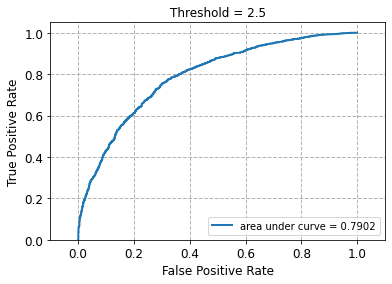

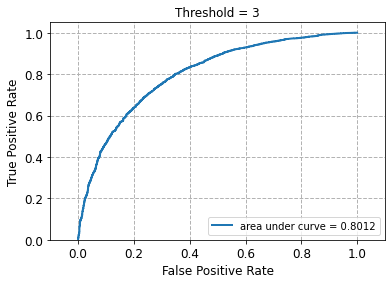

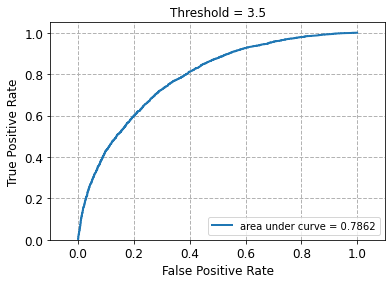

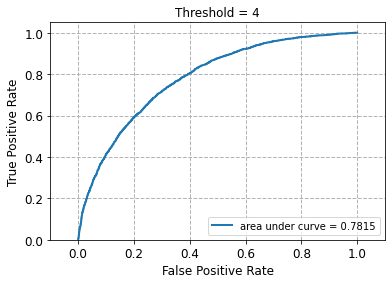

In [544]:
# Plotting the ROC Curves for SVD. Choosing K = 22
threshold = [2.5, 3, 3.5, 4]

bestSVDK = 22 #As seen above
for thresh in threshold:
    trainset, testset = train_test_split(readData, test_size=0.1)
    algo = SVD(n_factors=bestSVDK, verbose=False, random_state=42)
    
    algo.fit(trainset)
    
    predictions = algo.test(testset)
    
    pred = []
    actual = []
    
    for p in predictions:
        #Actual values at pos 2 and predictions at pos 3
        pred.append(p[3])
        actual.append(int(p[2] >= thresh))
        
    fpr, tpr, thresholds = metrics.roc_curve(actual, pred, pos_label=1)
    plot_roc(fpr,tpr)
    plt.title("Threshold = {}".format(thresh))
    plt.show()

Best K for MF Collaborative filter is <b>24</b> for RMSE error and <b>22</b> for MAE error. <br>

Total movie genres : 20. <b>(including no genre as a genre)</b><br>

Thus best number of latent factors are close to number of genres but not exactly same as to the number of genres.<br>

The AUC Scores for different threshold values are given below:

<b>2.5 - 0.7902 <br>
3.0 - 0.8012 <br>
3.5 - 0.7862<br>
4.0 - 0.7815

#### Naive collaborative filter

In [545]:
# Creating a dictionary to hold the average rating of each user.

avgUserRatings = ratings.groupby('userId')['rating'].mean().to_dict()

In [546]:
def getNaivePreds(testset):
    return [avgUserRatings[x[0]] for x in testset]
    
def getTrueLabels(testset):
    return [x[2] for x in testset]

In [547]:
avgRMSENCF = []

kf = KFold(n_splits=10)
a = []
for trainset, testset in kf.split(readData):
    preds = getNaivePreds(testset)
    trueLabels = getTrueLabels(testset)
    
    rmse = mean_squared_error(trueLabels, preds, squared=False)
    avgRMSENCF.append(rmse)

avgRMSENF = np.mean(avgRMSENCF)

In [548]:
print("Average RMSE for 10 fold cross validation using the Naive Collaborative filtering: {}".format(avgRMSENF))

Average RMSE for 10 fold cross validation using the Naive Collaborative filtering: 0.934687960432999


In [549]:
kf = KFold(n_splits=10)

avgPopularNCF = []
avgUnpopularNCF = []
avgHighVarNCF = []

for trainset, testset in kf.split(readData):
    tpop = getPopular(testset)
    preds = getNaivePreds(tpop)
    trueLabels = getTrueLabels(tpop)
    rmse = mean_squared_error(trueLabels, preds, squared=False)
    avgPopularNCF.append(rmse)
    
    tunpop = getUnpopular(testset)
    preds = getNaivePreds(tunpop)
    trueLabels = getTrueLabels(tunpop)
    rmse = mean_squared_error(trueLabels, preds, squared=False)
    avgUnpopularNCF.append(rmse)
    
    thvar = highVar(testset)
    preds = getNaivePreds(thvar)
    trueLabels = getTrueLabels(thvar)
    rmse = mean_squared_error(trueLabels, preds, squared=False)
    avgHighVarNCF.append(rmse)

In [550]:
# Getting overall averages:

avgPopularRMSENF = np.mean(avgPopularNCF)
avgUnPopularRMSENF = np.mean(avgUnpopularNCF)
avgHighVarRMSENF = np.mean(avgHighVarNCF)

In [551]:
print("Average RMSE for 10 fold cross validation for Popular Movies using the Naive Collaborative filtering: {}".format(avgPopularRMSENF))
print("Average RMSE for 10 fold cross validation for UnPopular Movies using the Naive Collaborative filtering: {}".format(avgUnPopularRMSENF))
print("Average RMSE for 10 fold cross validation for High Variance Movies using the Naive Collaborative filtering: {}".format(avgHighVarRMSENF))



Average RMSE for 10 fold cross validation for Popular Movies using the Naive Collaborative filtering: 0.9322994488718253
Average RMSE for 10 fold cross validation for UnPopular Movies using the Naive Collaborative filtering: 0.9710564506589254
Average RMSE for 10 fold cross validation for High Variance Movies using the Naive Collaborative filtering: 1.3742564550577998


### Question 11

Average RMSE for 10 fold cross validation using the Naive Collaborative filtering: <b>0.934687960432999</b>

Average RMSE for 10 fold cross validation for Popular Movies using the Naive Collaborative filtering: <b>0.9322994488718253</b>

Average RMSE for 10 fold cross validation for UnPopular Movies using the Naive Collaborative filtering: <b>0.9710564506589254</b>

Average RMSE for 10 fold cross validation for High Variance Movies using the Naive Collaborative filtering: <b>1.3742564550577998</b>

### Question 12

In [560]:
# Plotting ROC curves for all algorithms. MF, NMF, KNN.

trainset, testset = train_test_split(readData, test_size=0.1)

# Training and testing with best models from each class.

bestKNN = KNNWithMeans(k = bestK, sim_options=sim_options, verbose=False) #bestK = 20
bestNMF = NMF(n_factors=bestNMFK, verbose=False) #bestNMFK = 18
bestSVD = SVD(n_factors=bestSVDK, verbose=False, random_state=42) #bestSVDK = 22

bestKNN.fit(trainset)
bestNMF.fit(trainset)
bestSVD.fit(trainset)

predKNN = bestKNN.test(testset)
predNMF = bestNMF.test(testset)
predSVD = bestSVD.test(testset)

threshold3KNN = []
threshold3NMF = []
threshold3SVD = []
trueLabels = []

for i in range(len(predKNN)):
    #Actual values at pos 2 and predictions at pos 3
    trueLabels.append(int(predKNN[i][2] >= 3))
    threshold3KNN.append(predKNN[i][3])
    threshold3NMF.append(predNMF[i][3])
    threshold3SVD.append(predSVD[i][3])

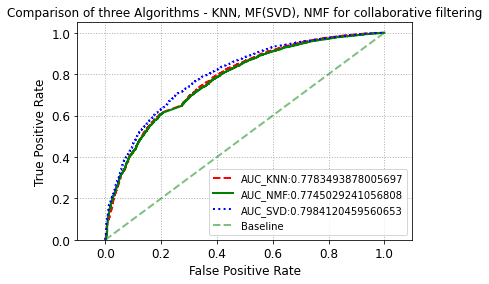

In [584]:
fig, ax = plt.subplots()

fpr, tpr, thresholds = metrics.roc_curve(trueLabels, threshold3KNN, pos_label=1)
roc_auc = metrics.auc(fpr,tpr)
ax.plot(fpr, tpr, lw=2, label="AUC_KNN:{}".format(roc_auc), linestyle='--', color='r')

fpr, tpr, thresholds = metrics.roc_curve(trueLabels, threshold3NMF, pos_label=1)
roc_auc = metrics.auc(fpr,tpr)
ax.plot(fpr, tpr, lw=2, label="AUC_NMF:{}".format(roc_auc), linestyle='solid', color='g')

fpr, tpr, thresholds = metrics.roc_curve(trueLabels, threshold3SVD, pos_label=1)
roc_auc = metrics.auc(fpr,tpr)
ax.plot(fpr, tpr, lw=2, label="AUC_SVD:{}".format(roc_auc), linestyle='dotted', color='b')

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='g', label='Baseline', alpha=.5)  

ax.grid(color='0.7', linestyle=':', linewidth=1)

ax.set_xlim([-0.1, 1.1])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate',fontsize=12)
ax.set_ylabel('True Positive Rate',fontsize=12)

ax.legend(loc="lower right")
ax.set_title("Comparison of three Algorithms - KNN, MF(SVD), NMF for collaborative filtering")


for label in ax.get_xticklabels()+ax.get_yticklabels():
    label.set_fontsize(12)

For Plotting above ROC curve, threshold value used = 3 <br>

For KNN with means, neighbours used = 20

For NMF number of latent factors used = 18

For MF (SVD) no of factors used = 22

<b>AUC for each CF: <br>
KNN : 0.7783 <br>
NMF : 0.7745 <br>
SVD : 0.7984 <br>
</b>

SVD performs best compared to other filters and KNN is better compared with NMF filter.

SVD is best because of the following reasons:

- SVD is able to represent high dimensional data better using projections which are deterministic compared to NMF which is sensitive to initialization and outliers.

- SVD is robust to outliers and biased traits as it does normalization and centering of data.

KNN is better compared to NMF. KNN performs good but not as good as SVD because it is sensitive to outliers and its efficiency and performance depends on how much dataset is balanced and if it's biased on not since it has to get neighbours which might not always be ideal for sparse data.


### Question 13

### Precision and recall in context of recommender systems

Precision in terms of classification problems means how much accurate a model is given it predicted a positive class. It gives the confidence on the positive prediction power of a model. A high precision mean the False positives are very low. <br>

In terms of recommender systems, precision is defined as the ratio of items a user actually liked from the given set of recommended items.

Recall in terms of classification problems is the measure of a model correctly identifying the true positives.A high recall means False negatives are very low. <br>

In terms of recommender systems, recall is defined as the whether all the items which are liked by the user are recommended by the model or not. 

In [721]:
def getUserCountDict(testset, threshold):
    userCountDict = {}
    nLikedMovies = {}
    
    for x in testset:
        userId = x[0]
        movieId = x[1]
        rating = x[2]
        
        nLikedMovies[userId] = []
        if rating >= threshold:
            nLikedMovies[userId].append(movieId)
        
        if userId not in userCountDict:
            userCountDict[userId] = []
        userCountDict[userId].append(movieId)
    
    return userCountDict, nLikedMovies

def getKSortedPreds(preds, t):
    sortedPreds = {}
    for p in preds:
        userId = p.uid
        movieId = p.iid
        rating = p.est
        
        if userId not in sortedPreds:
            sortedPreds[userId] = []
        sortedPreds[userId].append((movieId, rating))
            
    for key in sortedPreds:
        tup = sortedPreds[key]
        tup.sort(key = lambda x: x[1], reverse=True)
        sortedPreds[key] = [x[0] for x in tup[0 : t]]
    
    return sortedPreds

def getScores(preds, t, threshold):
    userRatingsDict = {}
    for pred in preds:
        uid = pred[0]
        trueR = pred[2]
        predR = pred[3]
        
        if uid not in userRatingsDict:
            userRatingsDict[uid] = []
        userRatingsDict[uid].append((predR, trueR))
    
    precisions = {}
    recalls = {}

    for uid, ratings in userRatingsDict.items():
        if (len(ratings) >= t):
            ratings.sort(key=lambda x: x[0], reverse=True)
            
            nLiked = sum([(tr >= threshold) for (pr, tr) in ratings])
            
            if (nLiked > 0):
                nRecommended = t

                nIntersect = sum([(tr >= threshold) and (pr >= threshold) for (pr, tr) in ratings[:t]])

                precisions[uid] = nIntersect / nRecommended
                recalls[uid] = nIntersect / nLiked

    return precisions, recalls


### Comparison of precision recall metrics.

In [722]:
tSweeps = np.arange(1, 26, 1)

threshold = 3
kf = KFold(n_splits=10)

modelDict = {
    0: KNNWithMeans(k = bestK, sim_options=sim_options, verbose=False),
    1: NMF(n_factors=bestNMFK, verbose=False),
    2: SVD(n_factors=bestSVDK, verbose=False, random_state=42)
}

scoresDict = {
    0: {
        'precision': [],
        'recall': []
    },
    1: {
        'precision': [],
        'recall': []
    },
    2: {
        'precision': [],
        'recall': []
    }
}

for t in tSweeps:
    print("sweeps completed: {}". format(t))
    for i in range(len(modelDict)):
        algo = modelDict[i]
        precision = []
        recall = []
        useCountDict = {}
        for trainset, testset in kf.split(readData):
            preds = algo.fit(trainset).test(testset)
            
            precs, recs = getScores(preds, t, threshold)
            
            precision.append(sum(precs.values()) / len(precs))
            recall.append(sum(recs.values()) / len(recs))
        
        scoresDict[i]['precision'].append(np.mean(precision))
        scoresDict[i]['recall'].append(np.mean(recall))

sweeps completed: 1
sweeps completed: 2
sweeps completed: 3
sweeps completed: 4
sweeps completed: 5
sweeps completed: 6
sweeps completed: 7
sweeps completed: 8
sweeps completed: 9
sweeps completed: 10
sweeps completed: 11
sweeps completed: 12
sweeps completed: 13
sweeps completed: 14
sweeps completed: 15
sweeps completed: 16
sweeps completed: 17
sweeps completed: 18
sweeps completed: 19
sweeps completed: 20
sweeps completed: 21
sweeps completed: 22
sweeps completed: 23
sweeps completed: 24
sweeps completed: 25


### Question 14

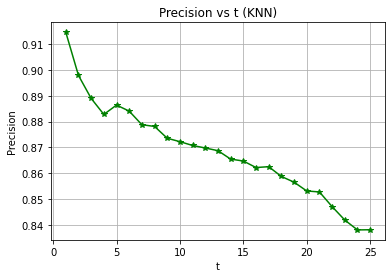

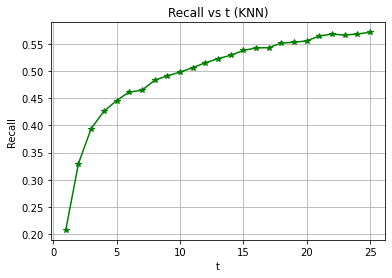

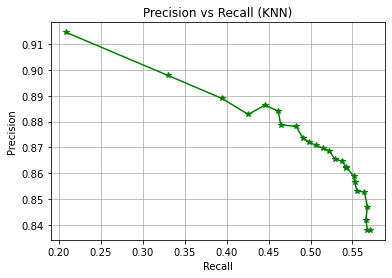

In [736]:
plt.plot(tSweeps, scoresDict[0]['precision'], marker = '*', color="green")
plt.title("Precision vs t (KNN)")
plt.xlabel("t")
plt.ylabel("Precision")
plt.grid()
plt.show()

plt.plot(tSweeps, scoresDict[0]['recall'], marker = '*', color="green")
plt.title("Recall vs t (KNN)")
plt.xlabel("t")
plt.ylabel("Recall")
plt.grid()
plt.show()

plt.plot(scoresDict[0]['recall'], scoresDict[0]['precision'], marker = '*', color="green")
plt.title("Precision vs Recall (KNN)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()

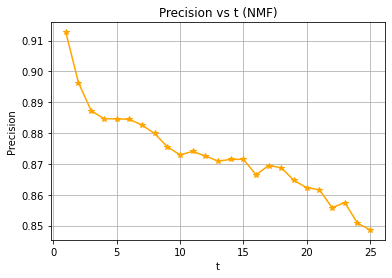

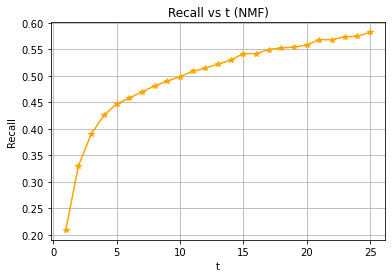

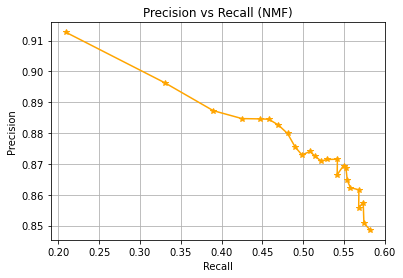

In [737]:
plt.plot(tSweeps, scoresDict[1]['precision'], marker = '*', color="orange")
plt.title("Precision vs t (NMF)")
plt.xlabel("t")
plt.ylabel("Precision")
plt.grid()
plt.show()

plt.plot(tSweeps, scoresDict[1]['recall'], marker = '*', color="orange")
plt.title("Recall vs t (NMF)")
plt.xlabel("t")
plt.ylabel("Recall")
plt.grid()
plt.show()

plt.plot(scoresDict[1]['recall'], scoresDict[1]['precision'], marker = '*', color="orange")
plt.title("Precision vs Recall (NMF)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()

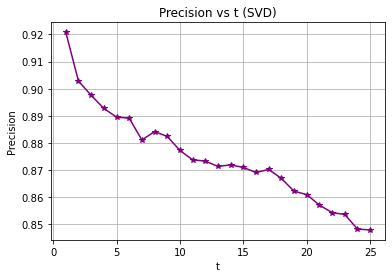

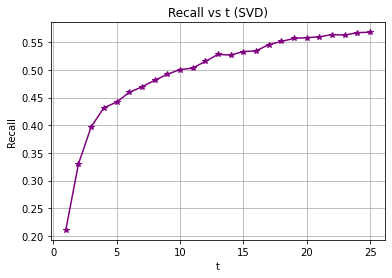

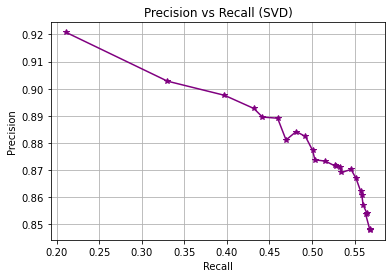

In [738]:
plt.plot(tSweeps, scoresDict[2]['precision'], marker = '*', color="purple")
plt.title("Precision vs t (SVD)")
plt.xlabel("t")
plt.ylabel("Precision")
plt.grid()
plt.show()

plt.plot(tSweeps, scoresDict[2]['recall'], marker = '*', color="purple")
plt.title("Recall vs t (SVD)")
plt.xlabel("t")
plt.ylabel("Recall")
plt.grid()
plt.show()

plt.plot(scoresDict[2]['recall'], scoresDict[2]['precision'], marker = '*', color="purple")
plt.title("Precision vs Recall (SVD)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()

Text(0.5, 1.0, 'Comparison of three Algorithms - KNN, MF(SVD), NMF for Precision vs Recall')

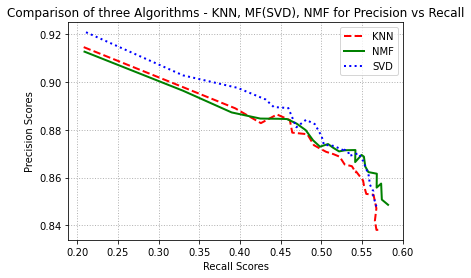

In [726]:
# Plotting precision/ recall curves.

fig, ax = plt.subplots()

ax.plot(scoresDict[0]['recall'], scoresDict[0]['precision'], lw=2, label="KNN", linestyle='--', color='r')
ax.plot(scoresDict[1]['recall'], scoresDict[1]['precision'], lw=2, label="NMF", linestyle='solid', color='g')
ax.plot(scoresDict[2]['recall'], scoresDict[2]['precision'], lw=2, label="SVD", linestyle='dotted', color='b')

ax.grid(color='0.7', linestyle=':', linewidth=1)

ax.set_xlabel('Recall Scores',fontsize=10)
ax.set_ylabel('Precision Scores',fontsize=10)

ax.legend(loc="upper right")
ax.set_title("Comparison of three Algorithms - KNN, MF(SVD), NMF for Precision vs Recall")


<b>The plots of Precision vs no. of recommendations(t), Recall vs no. of recommendations (t) and Precision vs Recall for all three Collaborative Filters are plotted above. </b> 

For KNN with means, neighbours used = 20

For NMF number of latent factors used = 18

For MF (SVD) no of factors used = 22

<b>For all the three filters I see that precision is decreasing as t increases but not monotonically. The fall is steep till t < 5 and then it's slope decreases. The decreasing behaviour is because as number of recommendations increase the filter is more likely to make more false positives i.e. recommendations which user might not actually like.</b>

<b>For recall, the score increases as t increases but not monotonically. Till t < 5 , the increase is very steep compared to higher t. The increasing behaviour of recall is because as the no. of recommendations increase, the filter will have more chance to include the movies which are actually liked by the user. </b>


<b>From Precision vs Recall, I can see that as recall increases, Precision is decreasing, this is because with increase in number of recommendations, the False Positives are increasing (the movies suggested but not liked by user) and at the same time False negatives are decreasing. (more items included which user actually likes.) </b>


From comparison plot of Precision vs recall for all of three filters, I see that:

MF with Bias (SVD) is performing best compared to KNN with Means and MF.

KNN with Means is performing better compared to NMF.

For SVD, precision drops slowly with increase in recall, compared to other two.

<b>Thus we can say that MF with Bias (SVD) gives much better recommendations to user and recommendations of KNN with means are better compared to NMF. </b>